In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
#from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns


import sys
import importlib
sys.path.append('../../helpers/')
import helper
sys.path.append('../../model/')
from ourModel import Classifier, train, test

In [2]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


# Prepare Dataset 

Load Dataset

In [3]:
importlib.reload(helper)
df = pd.read_csv('../../datasets/cancer/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Clean Data

In [4]:
remove_columns = ['id','Unnamed: 32']
df.drop(columns=remove_columns, inplace=True)
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)]
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
targets = [
    'diagnosis'
]

for x in targets:
    print(df[x].value_counts())


B    357
M    212
Name: diagnosis, dtype: int64


In [7]:
# encode the labels of the targets and create decoding dict
label_encoders = []
encoded_to_labels = []
for x in range(len(targets)):
    label_encoders.append(LabelEncoder())
    df[targets[x]] = label_encoders[x].fit_transform(df[targets[x]])
    encoded_to_labels.append({encoded: label for label, encoded in zip(label_encoders[x].classes_, label_encoders[x].transform(label_encoders[x].classes_))})



In [8]:
print(encoded_to_labels)

[{0: 'B', 1: 'M'}]


# Beyond here you dont have to mess with the dataframe anymore.

### Structure data for pytorch and split into training and testing splits

In [9]:
# dataset wrapper for the dataframe. Just a way to structure the data that pytorch likes and needs to then wrap with dataloader.

class DatasetWrapper(Dataset):
    def __init__(self, df : pd.DataFrame, target : str):
        self.n = df.shape[0]
        
        self.y = df[target].astype(np.int64).values

        self.scalar = StandardScaler()
        self.x = self.scalar.fit_transform(df.drop(columns=targets)).astype(np.float32)

    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
exp_dataset = DatasetWrapper(df, target=targets) # UPDATE for your experiments

# Split training and testing samples
train_size = int(0.8*len(exp_dataset)) # Use a different ratio if you want
test_size = len(exp_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(exp_dataset, [train_size, test_size])

print(f"Train length: {len(train_dataset)}, Test length: {len(test_dataset)}") # See the ratios

batch_size = 256 #Hyperparameter that you should try messing with depending on the size of your dataset. The smaller it is, the more stochastic and chaotic the training gets.

# Wrapping with dataloader so that its easy to extract batches from the train and test subsets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

Train length: 455, Test length: 114


## Model instantiation

In [10]:
num_features =  len(train_dataset[0][0])
num_targets =   len(train_dataset[0][1])
classes_per_target = [len(df[t].unique()) for t in targets ]

print(f"Features: {num_features}")
print(f"Targets: {num_targets}")
print(f"Classes per Target: {classes_per_target}")

Features: 30
Targets: 1
Classes per Target: [2]


In [11]:
#Updated with f1
model = Classifier(n_features=num_features, 
                                   pre_norm_on=True, 
                                   rff_on=True, 
                                   forward_expansion=1, 
                                   mlp_scale_classification=2, 
                                   targets_classes=classes_per_target
                                   ).to(device_in_use) # Instantiate the model


## Loss functions

In [12]:
loss_functions = []
#This loop could easily be adapted to us BinaryCrossEntropy for binary class and Cross for multi class
for x in targets:
    loss_functions.append(nn.CrossEntropyLoss())

optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.


## Train Test Loop

In [13]:
epochs = 40 #Set the number of epochs

In [14]:
train_losses = []
test_losses = []
train_accuracies = [[] for _ in range(num_targets)]
test_accuracies =  [[] for _ in range(num_targets)]

for t in range(epochs):
  train_loss, train_accuracy= train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy, all_predictions, all_targets, f1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)

  #Losses
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  #Accuracies
  for i in range(num_targets):
    train_accuracies[i].append(train_accuracy[i])
    test_accuracies[i].append(test_accuracy[i])
 
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"

  train_metrics = f"Train: Loss {train_loss:.2f}"
  for target, Acc in zip(targets, train_accuracy):
    train_metrics += f", {target} Accuracy: {Acc:.2f}"
  
  test_metrics = f"Test: Loss {test_loss:.2f}"
  for target, Acc, fone in zip(targets, test_accuracy, f1):
    test_metrics += f", {target} Accuracy: {Acc:.2f}, {target} F1: {fone:.2f}"

  print(f"{epoch_str:15} | {train_metrics} | {test_metrics}")


Epoch [ 1/40]   | Train: Loss 0.76, diagnosis Accuracy: 0.38 | Test: Loss 0.72, diagnosis Accuracy: 0.33, diagnosis F1: 0.17
Epoch [ 2/40]   | Train: Loss 0.70, diagnosis Accuracy: 0.48 | Test: Loss 0.66, diagnosis Accuracy: 0.67, diagnosis F1: 0.53
Epoch [ 3/40]   | Train: Loss 0.66, diagnosis Accuracy: 0.62 | Test: Loss 0.64, diagnosis Accuracy: 0.67, diagnosis F1: 0.53
Epoch [ 4/40]   | Train: Loss 0.67, diagnosis Accuracy: 0.62 | Test: Loss 0.63, diagnosis Accuracy: 0.67, diagnosis F1: 0.53
Epoch [ 5/40]   | Train: Loss 0.67, diagnosis Accuracy: 0.62 | Test: Loss 0.63, diagnosis Accuracy: 0.67, diagnosis F1: 0.53
Epoch [ 6/40]   | Train: Loss 0.67, diagnosis Accuracy: 0.62 | Test: Loss 0.63, diagnosis Accuracy: 0.67, diagnosis F1: 0.53
Epoch [ 7/40]   | Train: Loss 0.66, diagnosis Accuracy: 0.62 | Test: Loss 0.63, diagnosis Accuracy: 0.67, diagnosis F1: 0.53
Epoch [ 8/40]   | Train: Loss 0.66, diagnosis Accuracy: 0.62 | Test: Loss 0.63, diagnosis Accuracy: 0.67, diagnosis F1: 0.53


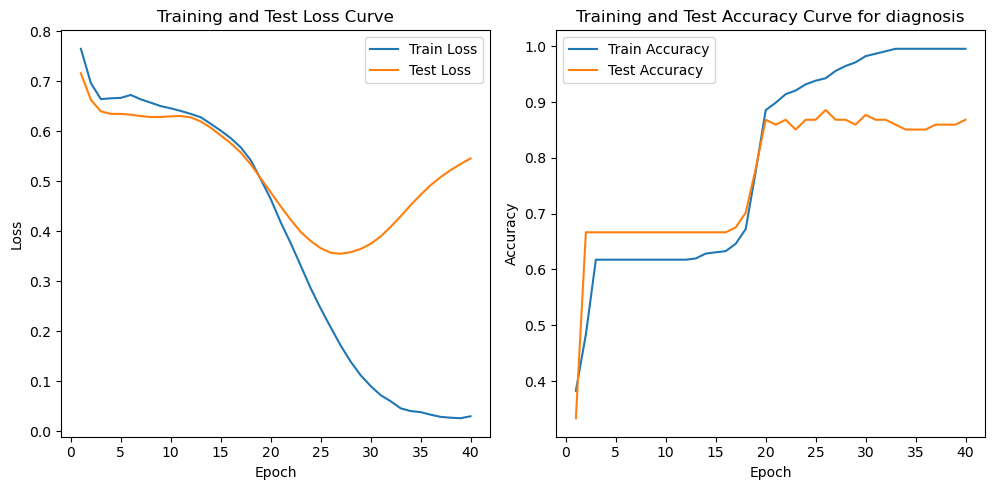

In [15]:
plot_num = 1
# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, plot_num)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plot_num+=1

for i in range(num_targets):
    plt.subplot(1, 3, plot_num)
    plt.plot(range(1, epochs+1), train_accuracies[i], label='Train Accuracy')
    plt.plot(range(1, epochs+1), test_accuracies[i], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Test Accuracy Curve for {targets[i]}')
    plt.legend()
    plot_num+=1


plt.tight_layout()
plt.tight_layout()
plt.show()


In [16]:
# actual_labels = [encoded_to_labels[i] for i in sorted(list(set(all_targets[i] + all_predictions[i])))]
# conf_matrix_1 = confusion_matrix(all_targets[i], all_predictions[i])
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix_1, annot=True, fmt="d", cmap="Blues", cbar=False,
#             xticklabels=actual_labels, yticklabels=actual_labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix for {targets[0]}')
# plt.show()